In [78]:
import math
from scipy.spatial.distance import cdist

# List to store customer objects
customers = []

# Matrix to store distances between customers
distance_matrix = []

class Customer:
    """
    Represents a customer in the vehicle routing problem.

    Attributes:
        cust_no (int): The customer number.
        x_coord (float): The x-coordinate of the customer's location.
        y_coord (float): The y-coordinate of the customer's location.
        demand (int): The demand of the customer.
        ready_time (int): The earliest time the customer is ready for service.
        due_date (int): The latest time the customer can be serviced.
        service_time (int): The time required to service the customer.
    """
    def __init__(self, cust_no, x_coord, y_coord, demand, ready_time, due_date, service_time):
        self.cust_no = cust_no
        self.x_coord = x_coord
        self.y_coord = y_coord
        self.demand = demand
        self.ready_time = ready_time
        self.due_date = due_date
        self.service_time = service_time

    def distance_to(self, other):
        """
        Calculates the distance to another customer.

        Parameters:
            other (Customer): The other customer to calculate the distance to.

        Returns:
            float: The distance to the other customer.
        """
        return distance_matrix[self.cust_no][other.cust_no]
    
    def __str__(self):
        return f"Customer {self.cust_no}"
    
    def __repr__(self):
        return self.__str__()

class Truck:
    """
    Represents a truck in the vehicle routing problem.

    Attributes:
        capacity (int): The capacity of the truck.
        route (list): The route of the truck, which is a list of customers.
        load (int): The current load of the truck.
        time (int): The current time of the truck.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.route = []
        self.load = 0
        self.time = 0

In [79]:
import random

class Ant:
    def __init__(self, customers, depot, trucks):
        """
        Initializes an Ant object.

        Parameters:
        customers (list): List of customer objects.
        depot (object): The depot (warehouse) object.
        trucks (list): List of truck objects.
        """
        self.customers = customers
        self.depot = depot
        self.trucks = trucks
        self.solution = []

    def construct_solution(self, pheromone, alpha, beta):
        """
        Constructs a solution for the ant by assigning customers to trucks.

        Parameters:
        pheromone (list): Pheromone levels between customers.
        alpha (float): Pheromone importance factor.
        beta (float): Heuristic importance factor.
        """
        unvisited = self.customers[:]
        random.shuffle(unvisited)
        for truck in self.trucks:
            truck.route = [self.depot]
            truck.load = 0
            truck.time = 0
            while unvisited:
                next_customer = self.select_next_customer(truck, unvisited, pheromone, alpha, beta)
                if next_customer is None:
                    break
                truck.route.append(next_customer)
                truck.load += next_customer.demand
                truck.time += truck.route[-2].distance_to(next_customer) + next_customer.service_time
                unvisited.remove(next_customer)
            truck.route.append(self.depot)
        self.solution = [truck.route for truck in self.trucks]

    def select_next_customer(self, truck, unvisited, pheromone, alpha, beta):
        """
        Selects the next customer for the truck to visit based on pheromone levels and heuristic information.

        Parameters:
        truck (object): The current truck object.
        unvisited (list): List of unvisited customer objects.
        pheromone (list): Pheromone levels between customers.
        alpha (float): Pheromone importance factor.
        beta (float): Heuristic importance factor.

        Returns:
        object: The next customer object to visit, or None if no feasible customer is found.
        """
        feasible_customers = [c for c in unvisited if truck.load + c.demand <= truck.capacity and truck.time + truck.route[-1].distance_to(c) <= c.due_date]
        if not feasible_customers:
            return None
        probabilities = []
        for customer in feasible_customers:
            pheromone_level = pheromone[truck.route[-1].cust_no][customer.cust_no]
            heuristic_value = 1 / (truck.route[-1].distance_to(customer) + 1e-6)
            probabilities.append((pheromone_level ** alpha) * (heuristic_value ** beta))
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
        return random.choices(feasible_customers, probabilities)[0]

In [80]:
import numpy as np

class ACO:
    def __init__(self, customers, depot, truck_count, truck_capacity, alpha=1.0, beta=2.0, rho=0.1, pheromone_init=1.0, iterations=100, ants_count=10):
        """
        Initializes the ACO algorithm with the given parameters.

        Parameters:
        customers (list): List of customer objects.
        depot (object): The depot (warehouse) object.
        truck_count (int): Number of trucks available.
        truck_capacity (int): Capacity of each truck.
        alpha (float): Importance of pheromone.
        beta (float): Importance of heuristic information.
        rho (float): Pheromone evaporation rate.
        pheromone_init (float): Initial pheromone level.
        iterations (int): Number of iterations to run the algorithm.
        ants_count (int): Number of ants to use in the algorithm.
        """
        self.customers = customers
        self.depot = depot
        self.truck_count = truck_count
        self.truck_capacity = truck_capacity
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.pheromone_init = pheromone_init
        self.iterations = iterations
        self.ants_count = ants_count
        self.pheromone = np.full((len(customers) + 1, len(customers) + 1), pheromone_init)

    def run(self):
        """
        Runs the ACO algorithm to find the best solution.

        Returns:
        tuple: Best solution found and its cost.
        """
        best_solution = None
        best_cost = float('inf')
        for _ in range(self.iterations):
            ants = [Ant(self.customers, self.depot, [Truck(self.truck_capacity) for _ in range(self.truck_count)]) for _ in range(self.ants_count)]
            for ant in ants:
                ant.construct_solution(self.pheromone, self.alpha, self.beta)
                cost = self.calculate_cost(ant.solution)
                if cost < best_cost:
                    best_cost = cost
                    best_solution = ant.solution
            self.update_pheromone(ants)
        return best_solution, best_cost

    def calculate_cost(self, solution):
        """
        Calculates the cost of a given solution.

        Parameters:
        solution (list): A list of routes, where each route is a list of customers.

        Returns:
        float: The total cost of the solution.
        """
        return sum(sum(route[i].distance_to(route[i + 1]) for i in range(len(route) - 1)) for route in solution)

    def update_pheromone(self, ants):
        """
        Updates the pheromone levels based on the solutions found by the ants.

        Parameters:
        ants (list): List of ant objects that have constructed solutions.
        """
        self.pheromone *= (1 - self.rho)
        for ant in ants:
            for route in ant.solution:
                for i in range(len(route) - 1):
                    self.pheromone[route[i].cust_no][route[i + 1].cust_no] += 1 / self.calculate_cost(ant.solution)

In [81]:
import matplotlib.pyplot as plt

def plot_routes(solution, depot):
    plt.figure(figsize=(10, 8))
    for route in solution:
        route_x = [depot.x_coord] + [customer.x_coord for customer in route[1:-1]] + [depot.x_coord]
        route_y = [depot.y_coord] + [customer.y_coord for customer in route[1:-1]] + [depot.y_coord]
        plt.plot(route_x, route_y, marker='o')
        # Show name on the point
        for i, customer in enumerate(route[1:-1]):
            plt.text(customer.x_coord, customer.y_coord, f"{customer.cust_no}", fontsize=9, ha='center', va='center')
    plt.scatter(depot.x_coord, depot.y_coord, c='red', label='Depot', s=100, marker='x')
    plt.title('Truck Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.legend()
    plt.show()

Best solution: [[Customer 100, Customer 85, Customer 98, Customer 37, Customer 59, Customer 93, Customer 97, Customer 94, Customer 6, Customer 89, Customer 58, Customer 13, Customer 87, Customer 40, Customer 53, Customer 75, Customer 22, Customer 41, Customer 72, Customer 74, Customer 73, Customer 2, Customer 21, Customer 56, Customer 4, Customer 55, Customer 25, Customer 24, Customer 54, Customer 35, Customer 34, Customer 50, Customer 77, Customer 68, Customer 80, Customer 12, Customer 52, Customer 31, Customer 7, Customer 82, Customer 48, Customer 70, Customer 1, Customer 0, Customer 26, Customer 3, Customer 83, Customer 5, Customer 96, Customer 95, Customer 100], [Customer 100, Customer 14, Customer 44, Customer 61, Customer 92, Customer 99, Customer 91, Customer 86, Customer 16, Customer 42, Customer 15, Customer 57, Customer 43, Customer 10, Customer 90, Customer 32, Customer 71, Customer 9, Customer 51, Customer 20, Customer 66, Customer 81, Customer 78, Customer 49, Customer 46,

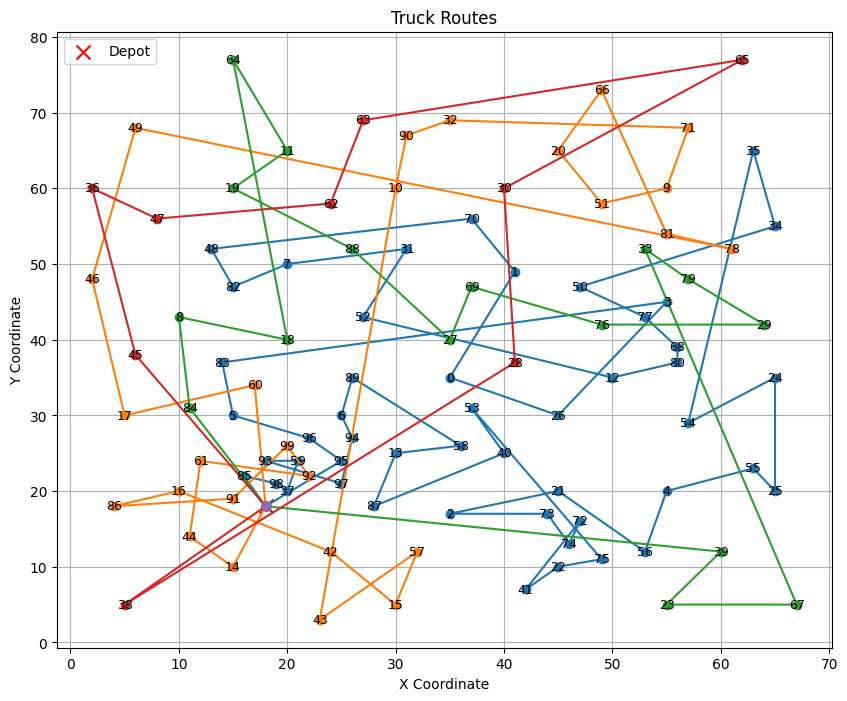

Truck 1: Capacity used = 727
Truck 2: Capacity used = 326
Truck 3: Capacity used = 238
Truck 4: Capacity used = 150
Total number of trucks used: 4


In [82]:
def print_truck_usage(solution):
    """
    Prints the capacity used by each truck and the total number of trucks used.
    
    Parameters:
    solution (list): A list of routes, where each route is a list of customers.
    """
    truck_count = 0  # Initialize the truck count
    for i, route in enumerate(solution):  # Iterate over each route in the solution
        load = sum(customer.demand for customer in route[1:-1])  # Calculate the load for the current route
        if load > 0:  # If the load is greater than 0
            truck_count += 1  # Increment the truck count
            print(f"Truck {i + 1}: Capacity used = {load}")  # Print the capacity used by the current truck
    print(f"Total number of trucks used: {truck_count}")  # Print the total number of trucks used

if __name__ == '__main__':
    file_path = 'r202.txt'  # Path to the input file

    # Reading the vehicle data (lines 3-4)
    vehicle_df = pd.read_csv(file_path, skiprows=4, nrows=1, sep='\\s+', names=['Number', 'Capacity'])
    
    # Reading the customer data (after line 9)
    customers_df = pd.read_csv(file_path, skiprows=9, sep='\\s+', names=['Cust No.', 'XCoord.', 'YCoord.', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])

    truck_count = vehicle_df['Number'][0]  # Get the number of trucks
    capacity = vehicle_df['Capacity'][0]  # Get the capacity of each truck

    # Create a list of Customer objects from the customer data
    customers = [Customer(row['Cust No.'], row['XCoord.'], row['YCoord.'], row['Demand'], row['Ready Time'], row['Due Date'], row['Service Time']) for index, row in customers_df.iterrows()]
    
    # Calculate the distance matrix between customers
    distance_matrix = cdist([[customer.x_coord, customer.y_coord] for customer in customers], [[customer.x_coord, customer.y_coord] for customer in customers], 'euclidean')
    
    # Define the depot (warehouse) as the last customer in the list
    warehouse = customers.pop()

    # Initialize the Ant Colony Optimization (ACO) algorithm
    aco = ACO(customers, warehouse, truck_count=truck_count, truck_capacity=capacity, iterations=50, ants_count=50)

    # Run the ACO algorithm to find the best solution
    best_solution, best_cost = aco.run()
    print("Best solution:", best_solution)  # Print the best solution found
    print("Best cost:", best_cost)  # Print the cost of the best solution
    
    # Plot the routes of the best solution
    plot_routes(best_solution, warehouse)
    
    # Print the truck usage details
    print_truck_usage(best_solution)